In [1]:
import os
from skimage import io, transform
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import math

In [2]:

class DriveDataset(Dataset):

    def __init__(self, csv_file, root_dir, bags, transform=None):
        self._csv_file = csv_file
        self._root_dir = root_dir
        self._bags = bags
        self._transform = transform
        self._frames = self.get_frames()

    def __len__(self):
        return len(self._frames)

    def __getitem__(self, idx):
        img_name = os.path.join(self._root_dir,
                        self._frames['bag'].iloc[idx],
                        self._frames['filename'].iloc[idx])
        image = io.imread(img_name)
        target = self._frames['angle'].iloc[idx]
        sample = {'image': image, 'steer': target}

        if self._transform:
            pass
            #sample = self._transform(sample)

        return sample

    def get_frames(self):
        file_paths = [
            (bag,os.path.join(self._root_dir, bag, self._csv_file))
            for bag in self._bags
        ]

        frames = []
        for bag,path in file_paths:
            df = pd.read_csv(path)
            df['bag'] = bag
            frames.append(df[df.frame_id=='center_camera'])
        return pd.concat(frames, axis=0)


In [51]:
bags = ['bag4','bag5']
root_dir = r'/home/tasuku/workspace/dl/algorithms/4-1-nvidia_end_to_end_self_driving/data/output'
csv_file = r'interpolated.csv'

In [9]:
data = DriveDataset(csv_file, root_dir, bags)
df = data.get_frames()
df.head()

,index,timestamp,width,height,frame_id,filename,angle,torque,speed,lat,long,alt,bag
0,2016-11-17 23:35:29.831388501,1479425729831388501,640,480,center_camera,center/1479425729831388501.png,0.016804,-0.101750,22.383010,37.492924,-122.382317,48.850685,bag4
3,2016-11-17 23:35:29.881120069,1479425729881120069,640,480,center_camera,center/1479425729881120069.png,0.014216,-0.231827,22.364697,37.492924,-122.382303,48.936434,bag4
6,2016-11-17 23:35:29.931106688,1479425729931106688,640,480,center_camera,center/1479425729931106688.png,0.005794,-0.271257,22.353667,37.492928,-122.382294,49.004865,bag4
9,2016-11-17 23:35:29.981076760,1479425729981076760,640,480,center_camera,center/1479425729981076760.png,-0.001174,-0.375000,22.334243,37.492928,-122.382278,49.091149,bag4
12,2016-11-17 23:35:30.031118702,1479425730031118702,640,480,center_camera,center/1479425730031118702.png,-0.008170,-0.353720,22.329609,37.492931,-122.382271,49.174645,bag4


[[227 197 163]
 [233 203 167]
 [238 208 172]
 ..., 
 [ 33  40  33]
 [ 36  43  35]
 [ 38  45  37]]


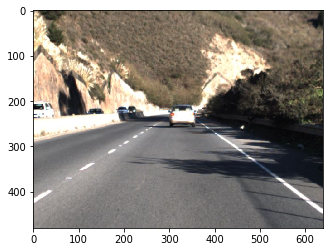

In [48]:
import matplotlib.pylab as plt
%matplotlib inline

image = io.imread(os.path.join(root_dir,df.bag.iloc[0],df.filename.iloc[0]))
plt.imshow(image)
print(image[10])

In [46]:
trans = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((66,200)),
            #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,hue=0.3)
            transforms.ToTensor()
])

In [49]:
trans(image)[0]


 0.7804  0.7608  0.7843  ...   0.2706  0.1843  0.1686
 0.8980  0.9137  0.8824  ...   0.1412  0.1020  0.1294
 0.9804  0.9255  0.8431  ...   0.0824  0.0824  0.1098
          ...             ⋱             ...          
 0.5843  0.6000  0.6000  ...   0.3333  0.3373  0.3373
 0.5765  0.5725  0.5569  ...   0.3961  0.3961  0.3804
 0.5451  0.5647  0.5765  ...   0.3843  0.3922  0.3922
[torch.FloatTensor of size 66x200]

In [50]:
# Not sure why but the transformation changes the range from 0-255 to 0-1...